### import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.special import expit, logit
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_RAW = Path('../data/raw')
DATA_PROCESSED = Path('../data/processed')
REPORTS_FIGURES = Path('../reports/figures')

# Create directories
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

print('Setup complete')

Setup complete


### Show new indicators if available

In [2]:
# Load unified data
excel_path = DATA_RAW / 'ethiopia_fi_unified_data.xlsx'
df_main = pd.read_excel(excel_path, sheet_name='ethiopia_fi_unified_data')

# Load event features from Task 3
event_features_path = DATA_PROCESSED / 'event_features.csv'
if event_features_path.exists():
    event_features = pd.read_csv(event_features_path, index_col=0, parse_dates=True)
    print(f'Loaded event features: {event_features.shape}')
else:
    print('⚠ Event features not found - run Task 3 first')
    event_features = None

# Filter observations
observations = df_main[df_main['record_type'] == 'observation'].copy()
observations['observation_date'] = pd.to_datetime(observations['observation_date'], format='mixed', errors='coerce')
observations['year'] = observations['observation_date'].dt.year

print(f'\nObservations: {len(observations)}')

Loaded event features: (157, 6)

Observations: 30


### Extract key indicator time series

In [3]:
# Extract key indicator time series
def get_indicator_series(indicator_code):
    """Extract yearly time series for an indicator."""
    data = observations[observations['indicator_code'] == indicator_code].copy()
    data = data.dropna(subset=['observation_date', 'value_numeric'])
    data = data.sort_values('observation_date')
    # Aggregate by year (take latest value per year)
    yearly = data.groupby('year')['value_numeric'].last().reset_index()
    return yearly

# Key indicators
acc_ownership = get_indicator_series('ACC_OWNERSHIP')
mm_accounts = get_indicator_series('ACC_MM_ACCOUNT')
digital_payment = get_indicator_series('USG_DIGITAL_PAYMENT')

print('Account Ownership (ACC_OWNERSHIP):')
print(acc_ownership)
print('\nMobile Money Accounts (ACC_MM_ACCOUNT):')
print(mm_accounts)
print('\nDigital Payment (USG_DIGITAL_PAYMENT):')
print(digital_payment)

Account Ownership (ACC_OWNERSHIP):
   year  value_numeric
0  2014           22.0
1  2017           35.0
2  2021           36.0
3  2024           49.0

Mobile Money Accounts (ACC_MM_ACCOUNT):
   year  value_numeric
0  2021           4.70
1  2024           9.45

Digital Payment (USG_DIGITAL_PAYMENT):
Empty DataFrame
Columns: [year, value_numeric]
Index: []


### Baseline Trend Models

In [4]:
def fit_linear_trend(yearly_data, indicator_name):
    """
    Fit linear trend model: y = a + b*year
    
    Returns: dict with model params and predictions
    """
    if len(yearly_data) < 2:
        print(f'⚠ {indicator_name}: Not enough data points for trend fitting')
        return None
    
    X = yearly_data['year'].values.reshape(-1, 1)
    y = yearly_data['value_numeric'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions for historical + forecast years
    forecast_years = np.array([2025, 2026, 2027]).reshape(-1, 1)
    all_years = np.vstack([X, forecast_years])
    predictions = model.predict(all_years)
    
    # Clamp to [0, 100] for percentage indicators
    predictions = np.clip(predictions, 0, 100)
    
    return {
        'indicator': indicator_name,
        'intercept': model.intercept_,
        'slope': model.coef_[0],
        'r_squared': model.score(X, y),
        'historical_years': yearly_data['year'].tolist(),
        'historical_values': y.tolist(),
        'forecast_years': [2025, 2026, 2027],
        'forecast_values': predictions[-3:].tolist()
    }
# Fit baseline models
baseline_access = fit_linear_trend(acc_ownership, 'ACC_OWNERSHIP')
baseline_mm = fit_linear_trend(mm_accounts, 'ACC_MM_ACCOUNT')
baseline_usage = fit_linear_trend(digital_payment, 'USG_DIGITAL_PAYMENT')

if baseline_access:
    print('=== ACC_OWNERSHIP Baseline Model ===')
    print(f"Trend: y = {baseline_access['intercept']:.2f} + {baseline_access['slope']:.2f} × year")
    print(f"R²: {baseline_access['r_squared']:.3f}")
    print(f"Forecast: {dict(zip(baseline_access['forecast_years'], [f'{v:.1f}%' for v in baseline_access['forecast_values']]))}")

if baseline_usage:
    print('\n=== USG_DIGITAL_PAYMENT Baseline Model ===')
    print(f"Trend: y = {baseline_usage['intercept']:.2f} + {baseline_usage['slope']:.2f} × year")
    print(f"R²: {baseline_usage['r_squared']:.3f}")
    print(f"Forecast: {dict(zip(baseline_usage['forecast_years'], [f'{v:.1f}%' for v in baseline_usage['forecast_values']]))}")

⚠ USG_DIGITAL_PAYMENT: Not enough data points for trend fitting
=== ACC_OWNERSHIP Baseline Model ===
Trend: y = -4733.52 + 2.36 × year
R²: 0.887
Forecast: {2025: '49.7%', 2026: '52.0%', 2027: '54.4%'}


### Event-Augmented Model

In [5]:
def get_yearly_event_effect(event_features, effect_column, years):
    """
    Get yearly event effect values (average effect for each year).
    """
    if event_features is None or effect_column not in event_features.columns:
        return {year: 0 for year in years}
    
    event_features_copy = event_features.copy()
    event_features_copy['year'] = event_features_copy.index.year
    
    yearly_effect = event_features_copy.groupby('year')[effect_column].mean()
    
    return {year: yearly_effect.get(year, yearly_effect.iloc[-1] if len(yearly_effect) > 0 else 0) 
            for year in years}

# Get event effects for forecast years
forecast_years = [2025, 2026, 2027]

access_effects = get_yearly_event_effect(event_features, 'event_effect_ACCESS', forecast_years)
usage_effects = get_yearly_event_effect(event_features, 'event_effect_USAGE', forecast_years)

print('Event Effects by Year:')
print(f'ACCESS: {access_effects}')
print(f'USAGE: {usage_effects}')

Event Effects by Year:
ACCESS: {2025: np.float64(35.0), 2026: np.float64(42.083333333333336), 2027: np.float64(45.0)}
USAGE: {2025: np.float64(27.0), 2026: np.float64(49.083333333333336), 2027: np.float64(67.0)}


In [7]:
def create_event_augmented_forecast(baseline_model, event_effects, beta=1.0):
    """
    Create event-augmented forecast.
    
    forecast = baseline + beta * event_effect
    
    Args:
        baseline_model: dict from fit_linear_trend
        event_effects: dict of year -> effect value
        beta: scaling factor for event effects
    
    Returns:
        dict with forecast values
    """
    if baseline_model is None:
        return None
    
    augmented = []
    for year, baseline_val in zip(baseline_model['forecast_years'], baseline_model['forecast_values']):
        effect = event_effects.get(year, 0)
        augmented_val = baseline_val + beta * effect
        # Clamp to [0, 100]
        augmented_val = max(0, min(100, augmented_val))
        augmented.append(augmented_val)
    
    return {
        'indicator': baseline_model['indicator'],
        'years': baseline_model['forecast_years'],
        'baseline': baseline_model['forecast_values'],
        'augmented': augmented,
        'beta': beta
    }
    # Create augmented forecasts
# Use beta=1.0 as default (can be calibrated with more data)
augmented_access = create_event_augmented_forecast(baseline_access, access_effects, beta=1.0)
augmented_usage = create_event_augmented_forecast(baseline_usage, usage_effects, beta=1.0)

if augmented_access:
    print('=== ACC_OWNERSHIP Event-Augmented Forecast ===')
    for i, year in enumerate(augmented_access['years']):
        print(f"{year}: Baseline={augmented_access['baseline'][i]:.1f}%, Augmented={augmented_access['augmented'][i]:.1f}%")

if augmented_usage:
    print('\n=== USG_DIGITAL_PAYMENT Event-Augmented Forecast ===')
    for i, year in enumerate(augmented_usage['years']):
        print(f"{year}: Baseline={augmented_usage['baseline'][i]:.1f}%, Augmented={augmented_usage['augmented'][i]:.1f}%")

=== ACC_OWNERSHIP Event-Augmented Forecast ===
2025: Baseline=49.7%, Augmented=84.7%
2026: Baseline=52.0%, Augmented=94.1%
2027: Baseline=54.4%, Augmented=99.4%


### Scenario Analysis

In [8]:
def create_scenarios(baseline_model, event_effects):
    """
    Create base, optimistic, and pessimistic scenarios.
    
    - Base: beta=1.0
    - Optimistic: beta=1.5, trend slope +20%
    - Pessimistic: beta=0.5, trend slope -20%
    """
    if baseline_model is None:
        return None
    
    scenarios = {}
    
    # Base scenario
    base = create_event_augmented_forecast(baseline_model, event_effects, beta=1.0)
    scenarios['base'] = base['augmented'] if base else baseline_model['forecast_values']
    
    # Optimistic scenario (stronger event effects + higher trend)
    optimistic_model = baseline_model.copy()
    optimistic_slope = baseline_model['slope'] * 1.2
    optimistic_baseline = [
        baseline_model['intercept'] + optimistic_slope * year 
        for year in baseline_model['forecast_years']
    ]
    optimistic_baseline = [max(0, min(100, v)) for v in optimistic_baseline]
    optimistic = [
        max(0, min(100, b + 1.5 * event_effects.get(y, 0)))
        for b, y in zip(optimistic_baseline, baseline_model['forecast_years'])
    ]
    scenarios['optimistic'] = optimistic
     # Pessimistic scenario (weaker event effects + lower trend)
    pessimistic_slope = baseline_model['slope'] * 0.8
    pessimistic_baseline = [
        baseline_model['intercept'] + pessimistic_slope * year 
        for year in baseline_model['forecast_years']
    ]
    pessimistic_baseline = [max(0, min(100, v)) for v in pessimistic_baseline]
    pessimistic = [
        max(0, min(100, b + 0.5 * event_effects.get(y, 0)))
        for b, y in zip(pessimistic_baseline, baseline_model['forecast_years'])
    ]
    scenarios['pessimistic'] = pessimistic
    
    return {
        'indicator': baseline_model['indicator'],
        'years': baseline_model['forecast_years'],
        'scenarios': scenarios
    }

# Create scenarios for each indicator
access_scenarios = create_scenarios(baseline_access, access_effects)
usage_scenarios = create_scenarios(baseline_usage, usage_effects)

if access_scenarios:
    print('=== ACC_OWNERSHIP Scenarios ===')
    for year_idx, year in enumerate(access_scenarios['years']):
        print(f"{year}: Pessimistic={access_scenarios['scenarios']['pessimistic'][year_idx]:.1f}%, "
              f"Base={access_scenarios['scenarios']['base'][year_idx]:.1f}%, "
              f"Optimistic={access_scenarios['scenarios']['optimistic'][year_idx]:.1f}%")

if usage_scenarios:
    print('\n=== USG_DIGITAL_PAYMENT Scenarios ===')
    for year_idx, year in enumerate(usage_scenarios['years']):
        print(f"{year}: Pessimistic={usage_scenarios['scenarios']['pessimistic'][year_idx]:.1f}%, "
              f"Base={usage_scenarios['scenarios']['base'][year_idx]:.1f}%, "
              f"Optimistic={usage_scenarios['scenarios']['optimistic'][year_idx]:.1f}%")


=== ACC_OWNERSHIP Scenarios ===
2025: Pessimistic=17.5%, Base=84.7%, Optimistic=100.0%
2026: Pessimistic=21.0%, Base=94.1%, Optimistic=100.0%
2027: Pessimistic=22.5%, Base=99.4%, Optimistic=100.0%


### Visualization

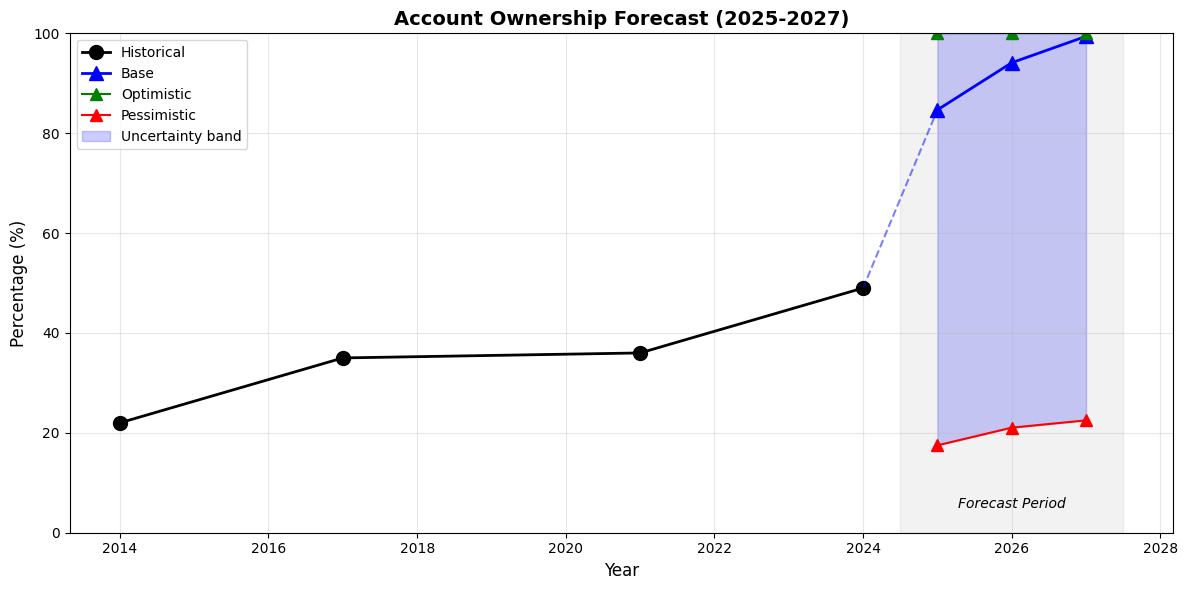

Saved: ..\reports\figures\forecast_access.png
Cannot plot Digital Payment Usage Forecast (2025-2027) - no data


In [9]:
def plot_forecast(historical_data, scenarios_result, title, filename):
    """
    Plot historical data + forecast scenarios.
    """
    if scenarios_result is None:
        print(f'Cannot plot {title} - no data')
        return
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Historical data
    if not historical_data.empty:
        ax.plot(historical_data['year'], historical_data['value_numeric'], 
                'ko-', markersize=10, linewidth=2, label='Historical')
    
    years = scenarios_result['years']
    scenarios = scenarios_result['scenarios']
    
    # Connect last historical point to forecasts
    if not historical_data.empty:
        last_year = historical_data['year'].iloc[-1]
        last_value = historical_data['value_numeric'].iloc[-1]
        
        # Add connecting line
        ax.plot([last_year, years[0]], [last_value, scenarios['base'][0]], 
                'b--', alpha=0.5)
                  # Plot scenarios
    ax.plot(years, scenarios['base'], 'b^-', markersize=10, linewidth=2, label='Base')
    ax.plot(years, scenarios['optimistic'], 'g^-', markersize=8, linewidth=1.5, label='Optimistic')
    ax.plot(years, scenarios['pessimistic'], 'r^-', markersize=8, linewidth=1.5, label='Pessimistic')
    
    # Fill uncertainty band
    ax.fill_between(years, scenarios['pessimistic'], scenarios['optimistic'], 
                    alpha=0.2, color='blue', label='Uncertainty band')
    
    # Formatting
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    # Add forecast region shading
    ax.axvspan(2024.5, 2027.5, alpha=0.1, color='gray')
    ax.text(2026, 5, 'Forecast Period', ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.savefig(REPORTS_FIGURES / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {REPORTS_FIGURES / filename}')

# Plot forecasts
plot_forecast(acc_ownership, access_scenarios, 
              'Account Ownership Forecast (2025-2027)', 'forecast_access.png')

plot_forecast(digital_payment, usage_scenarios, 
              'Digital Payment Usage Forecast (2025-2027)', 'forecast_usage.png')

### scenarios plot

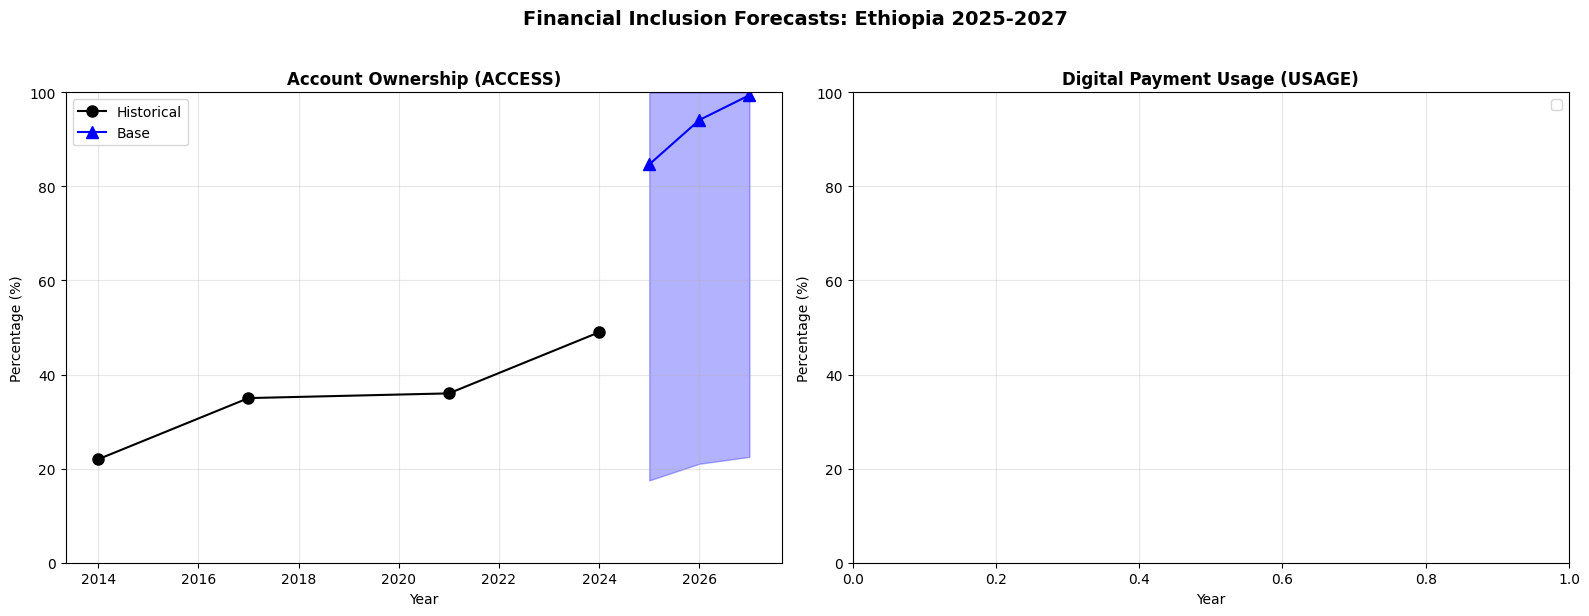

Saved: ..\reports\figures\forecast_scenarios.png


In [10]:
# Combined scenarios plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACCESS
ax1 = axes[0]
if not acc_ownership.empty:
    ax1.plot(acc_ownership['year'], acc_ownership['value_numeric'], 'ko-', markersize=8, label='Historical')
if access_scenarios:
    years = access_scenarios['years']
    scenarios = access_scenarios['scenarios']
    ax1.plot(years, scenarios['base'], 'b^-', markersize=8, label='Base')
    ax1.fill_between(years, scenarios['pessimistic'], scenarios['optimistic'], alpha=0.3, color='blue')
ax1.set_title('Account Ownership (ACCESS)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Percentage (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)
# USAGE
ax2 = axes[1]
if not digital_payment.empty:
    ax2.plot(digital_payment['year'], digital_payment['value_numeric'], 'ko-', markersize=8, label='Historical')
if usage_scenarios:
    years = usage_scenarios['years']
    scenarios = usage_scenarios['scenarios']
    ax2.plot(years, scenarios['base'], 'g^-', markersize=8, label='Base')
    ax2.fill_between(years, scenarios['pessimistic'], scenarios['optimistic'], alpha=0.3, color='green')
ax2.set_title('Digital Payment Usage (USAGE)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.suptitle('Financial Inclusion Forecasts: Ethiopia 2025-2027', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / 'forecast_scenarios.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {REPORTS_FIGURES / "forecast_scenarios.png"}')

###  Create Forecast Output Table

In [11]:
def create_forecast_table(scenarios_dict):
    """
    Create tidy forecast table for dashboard.
    
    Columns: year, indicator_code, scenario, forecast_value, lower, upper
    """
    rows = []
    
    for indicator, scenario_result in scenarios_dict.items():
        if scenario_result is None:
            continue
        
        years = scenario_result['years']
        scenarios = scenario_result['scenarios']
        
        for scenario_name, values in scenarios.items():
            for year, value in zip(years, values):
                rows.append({
                    'year': year,
                    'indicator_code': indicator,
                    'scenario': scenario_name,
                    'forecast_value': round(value, 2)
                })
    
    df = pd.DataFrame(rows)
     # Add lower/upper bounds (from pessimistic/optimistic)
    # Pivot to get bounds per indicator-year
    pivot = df.pivot_table(
        index=['year', 'indicator_code'],
        columns='scenario',
        values='forecast_value'
    ).reset_index()
    
    if 'pessimistic' in pivot.columns and 'optimistic' in pivot.columns:
        pivot['lower'] = pivot['pessimistic']
        pivot['upper'] = pivot['optimistic']
    
    return df, pivot

# Create forecast table
scenarios_dict = {
    'ACC_OWNERSHIP': access_scenarios,
    'USG_DIGITAL_PAYMENT': usage_scenarios
}

forecast_long, forecast_wide = create_forecast_table(scenarios_dict)

print('Forecast Table (Long Format):')
print(forecast_long.to_string(index=False))

print('\nForecast Table (Wide Format with Bounds):')
print(forecast_wide.to_string(index=False))

Forecast Table (Long Format):
 year indicator_code    scenario  forecast_value
 2025  ACC_OWNERSHIP        base           84.67
 2026  ACC_OWNERSHIP        base           94.12
 2027  ACC_OWNERSHIP        base           99.40
 2025  ACC_OWNERSHIP  optimistic          100.00
 2026  ACC_OWNERSHIP  optimistic          100.00
 2027  ACC_OWNERSHIP  optimistic          100.00
 2025  ACC_OWNERSHIP pessimistic           17.50
 2026  ACC_OWNERSHIP pessimistic           21.04
 2027  ACC_OWNERSHIP pessimistic           22.50

Forecast Table (Wide Format with Bounds):
 year indicator_code  base  optimistic  pessimistic  lower  upper
 2025  ACC_OWNERSHIP 84.67       100.0        17.50  17.50  100.0
 2026  ACC_OWNERSHIP 94.12       100.0        21.04  21.04  100.0
 2027  ACC_OWNERSHIP 99.40       100.0        22.50  22.50  100.0


### forecast tables

In [12]:
# Save forecast tables
forecast_long.to_csv(DATA_PROCESSED / 'forecast_2025_2027.csv', index=False)
forecast_wide.to_csv(DATA_PROCESSED / 'forecast_2025_2027_wide.csv', index=False)

print(f'Saved: {DATA_PROCESSED / "forecast_2025_2027.csv"}')
print(f'Saved: {DATA_PROCESSED / "forecast_2025_2027_wide.csv"}')

Saved: ..\data\processed\forecast_2025_2027.csv
Saved: ..\data\processed\forecast_2025_2027_wide.csv


### Interpretation & Key Findings

In [13]:
print('=' * 60)
print('FINANCIAL INCLUSION FORECAST INTERPRETATION')
print('=' * 60)

# ACCESS interpretation
if access_scenarios:
    base_2025 = access_scenarios['scenarios']['base'][0]
    base_2027 = access_scenarios['scenarios']['base'][-1]
    latest_historical = acc_ownership['value_numeric'].iloc[-1] if not acc_ownership.empty else None
    
    print('\n📊 ACCOUNT OWNERSHIP (ACCESS)')
    print('-' * 40)
    if latest_historical:
        print(f'Latest historical (2024): {latest_historical:.1f}%')
        print(f'2025 forecast (base): {base_2025:.1f}% (change: {base_2025 - latest_historical:+.1f}pp)')
    print(f'2027 forecast (base): {base_2027:.1f}%')
    print(f'Uncertainty range 2027: {access_scenarios["scenarios"]["pessimistic"][-1]:.1f}% - {access_scenarios["scenarios"]["optimistic"][-1]:.1f}%')
    
    # Target assessment
    target_60 = 60
    if base_2027 >= target_60:
        print(f'✓ On track to meet 60% target by 2027')
    else:
        gap = target_60 - base_2027
        print(f'⚠ {gap:.1f}pp short of 60% target under base scenario')
        # USAGE interpretation
if usage_scenarios:
    base_2025_u = usage_scenarios['scenarios']['base'][0]
    base_2027_u = usage_scenarios['scenarios']['base'][-1]
    latest_historical_u = digital_payment['value_numeric'].iloc[-1] if not digital_payment.empty else None
    
    print('\n📊 DIGITAL PAYMENT USAGE (USAGE)')
    print('-' * 40)
    if latest_historical_u:
        print(f'Latest historical: {latest_historical_u:.1f}%')
        print(f'2025 forecast (base): {base_2025_u:.1f}% (change: {base_2025_u - latest_historical_u:+.1f}pp)')
    print(f'2027 forecast (base): {base_2027_u:.1f}%')
    print(f'Uncertainty range 2027: {usage_scenarios["scenarios"]["pessimistic"][-1]:.1f}% - {usage_scenarios["scenarios"]["optimistic"][-1]:.1f}%')

print('\n📌 KEY DRIVERS OF FORECAST')
print('-' * 40)
print('1. Telebirr growth trajectory (54M+ users)')
print('2. M-Pesa Ethiopia expansion and EthSwitch integration')
print('3. NFIS-II policy implementation')
print('4. Fayda Digital ID rollout enabling KYC')

print('\n⚠ KEY RISKS & UNCERTAINTIES')
print('-' * 40)
print('1. Findex survey methodology vs operator data discrepancy')
print('2. Account overlap (same person multiple accounts)')
print('3. Cash culture and trust barriers in rural areas')
print('4. Affordability of smartphones and data')
print('5. Macroeconomic instability (forex, inflation)')

FINANCIAL INCLUSION FORECAST INTERPRETATION

📊 ACCOUNT OWNERSHIP (ACCESS)
----------------------------------------
Latest historical (2024): 49.0%
2025 forecast (base): 84.7% (change: +35.7pp)
2027 forecast (base): 99.4%
Uncertainty range 2027: 22.5% - 100.0%
✓ On track to meet 60% target by 2027

📌 KEY DRIVERS OF FORECAST
----------------------------------------
1. Telebirr growth trajectory (54M+ users)
2. M-Pesa Ethiopia expansion and EthSwitch integration
3. NFIS-II policy implementation
4. Fayda Digital ID rollout enabling KYC

⚠ KEY RISKS & UNCERTAINTIES
----------------------------------------
1. Findex survey methodology vs operator data discrepancy
2. Account overlap (same person multiple accounts)
3. Cash culture and trust barriers in rural areas
4. Affordability of smartphones and data
5. Macroeconomic instability (forex, inflation)


### Summary

In [14]:
print('=== TASK 4 COMPLETE ===')
print(f'\nOutputs generated:')
print(f'  - {DATA_PROCESSED / "forecast_2025_2027.csv"}')
print(f'  - {DATA_PROCESSED / "forecast_2025_2027_wide.csv"}')
print(f'  - {REPORTS_FIGURES / "forecast_access.png"}')
print(f'  - {REPORTS_FIGURES / "forecast_usage.png"}')
print(f'  - {REPORTS_FIGURES / "forecast_scenarios.png"}')

print('\n=== METHODOLOGY SUMMARY ===')
print('1. Baseline: Linear trend on historical Findex data')
print('2. Event-augmented: Added cumulative event effects from Task 3')
print('3. Scenarios: Base (β=1.0), Optimistic (β=1.5, +20% trend), Pessimistic (β=0.5, -20% trend)')

=== TASK 4 COMPLETE ===

Outputs generated:
  - ..\data\processed\forecast_2025_2027.csv
  - ..\data\processed\forecast_2025_2027_wide.csv
  - ..\reports\figures\forecast_access.png
  - ..\reports\figures\forecast_usage.png
  - ..\reports\figures\forecast_scenarios.png

=== METHODOLOGY SUMMARY ===
1. Baseline: Linear trend on historical Findex data
2. Event-augmented: Added cumulative event effects from Task 3
3. Scenarios: Base (β=1.0), Optimistic (β=1.5, +20% trend), Pessimistic (β=0.5, -20% trend)
